In [3]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

train_input = input_variables[:80]
train_output = output_variable[:80]

test_input = input_variables[80:]
test_output = output_variable[80:]

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


10 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


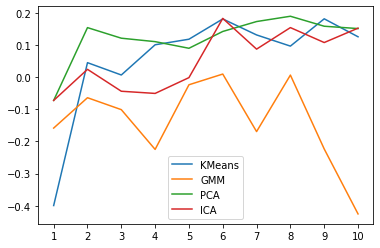

In [4]:
def plot_each_k_cluster(i):
  ### K-means ####
  kmeans = KMeans(n_clusters=i).fit(train_input) ### feature engineering on train_split
  kmeans_input_variables= kmeans.transform(input_variables)
  # kmeans_test_input = kmeans.transform(test_input)

  ### GMM ####
  GMM = GaussianMixture(n_components=i).fit(train_input) ### feature engineering on train_split
  gmm_input_variables = GMM.predict_proba(input_variables)
  # GMM_test_input = GMM.predict_proba(test_input)

  ### PCA ####
  pca = PCA(n_components=i).fit(train_input) ### feature engineering on train_split
  pca_input_variables = pca.transform(input_variables)
  # pca_test_input = pca.transform(test_input)

  ### ICA ####
  ica = FastICA(n_components=i).fit(train_input) ### feature engineering on train_split
  ica_input_variables = ica.transform(input_variables)
  # ica_test_input = ica.transform(test_input)

  kf = KFold(n_splits=5)

  km_accuracy = 0
  gmm_accuracy = 0
  pca_accuracy = 0
  ica_accuracy = 0

  for train_index, test_index in kf.split(output_variable):
    ######### KMeans #########
    kmeans_X_train, kmeans_X_test = kmeans_input_variables[train_index], kmeans_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    kmeans_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(kmeans_X_train, y_train)
    kmeans_log_predict_output = kmeans_Logmodel.predict(kmeans_X_test)
    km_accuracy += r2_score(y_test, kmeans_log_predict_output)

    ######### GMM #########
    gmm_X_train, gmm_X_test = gmm_input_variables[train_index], gmm_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    gmm_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(gmm_X_train, y_train)
    gmm_log_predict_output = gmm_Logmodel.predict(gmm_X_test)
    gmm_accuracy += r2_score(y_test, gmm_log_predict_output)

    ######### PCA #########
    pca_X_train, pca_X_test = pca_input_variables[train_index], pca_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    pca_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(pca_X_train, y_train)
    pca_log_predict_output = pca_Logmodel.predict(pca_X_test)
    pca_accuracy += r2_score(y_test, pca_log_predict_output)

    ######### ICA #########
    ica_X_train, ica_X_test = ica_input_variables[train_index], ica_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    ica_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(ica_X_train, y_train)
    ica_log_predict_output = ica_Logmodel.predict(ica_X_test)
    ica_accuracy += r2_score(y_test, ica_log_predict_output)

  return i, km_accuracy/5, gmm_accuracy/5, pca_accuracy/5, ica_accuracy/5 #, KNN_accuracy


x_list = [] ### n_rois
km_y_list = [] ### accuracy
gmm_y_list = [] ### accuracy
pca_y_list = [] ### accuracy
ica_y_list = [] ### accuracy

# KNN_y_list = []

for i in range (1,11):
  i, km_accuracy, gmm_accuracy, pca_accuracy, ica_accuracy = plot_each_k_cluster(i)

  # print("i: ", i,"accuracy: ", accuracy)
  x_list.append(i)
  # log_y_list.append(log_accuracy)
  # KNN_y_list.append(KNN_accuracy)
  km_y_list.append(km_accuracy)
  gmm_y_list.append(gmm_accuracy)
  pca_y_list.append(pca_accuracy)
  ica_y_list.append(ica_accuracy)

# print(x_list)
# print(log_y_list)
# print(KNN_y_list)
plt.xticks(x_list)
# plt.plot(x_list,log_y_list,label='LogReg')
# plt.plot(x_list,KNN_y_list,label='KNN')
plt.plot(x_list,km_y_list,label='KMeans')
plt.plot(x_list,gmm_y_list,label='GMM')
plt.plot(x_list,pca_y_list,label='PCA')
plt.plot(x_list,ica_y_list,label='ICA')
plt.legend()
plt.show()